In [2]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import cross_validation
from sklearn import tree as Tree
import sklearn.tree
%matplotlib inline 

## Load in data

In [3]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/80_20_processed_data/dumble_8020_df.csv',index_col=0)

In [4]:
data.head(5)

,Previous_10_Left_Choice,Previous_10_Right_Choice,Previous_10_Left_Reward,Previous_10_Right_Reward,Streak,5_Port,5_Reward,5_ITI,5_trialDuration,4_Port,...,2_Reward,2_ITI,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,0_trialDuration,Decision
0,10.0,0.0,8.0,0.0,-1.0,1.0,0.0,3.286,0.407,1.0,...,1.0,2.234,0.325,1.0,0.0,2.133,0.482,1.411,0.435,1.0
1,10.0,0.0,7.0,0.0,-2.0,1.0,1.0,2.405,0.463,1.0,...,0.0,2.133,0.482,1.0,0.0,1.411,0.435,2.169,0.395,0.0
2,9.0,1.0,6.0,0.0,-3.0,1.0,1.0,2.379,0.367,1.0,...,0.0,1.411,0.435,0.0,0.0,2.169,0.395,3.838,0.469,0.0
3,8.0,2.0,5.0,0.0,-4.0,1.0,1.0,2.234,0.325,1.0,...,0.0,2.169,0.395,0.0,0.0,3.838,0.469,1.846,0.378,1.0
4,8.0,2.0,5.0,0.0,1.0,1.0,0.0,2.133,0.482,1.0,...,0.0,3.838,0.469,1.0,1.0,1.846,0.378,1.527,0.416,1.0


In [5]:
#extract features and decisions
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

# Change 'y' so that 1 corresponds to a switch, and 0 corresponds to no switch

In [6]:
y_diff = np.diff(y)
x = x[:-1,:]
y = np.abs(y_diff.copy())

print(x.shape)
print(y_diff.shape)

(5861, 27)
(5861,)


In [7]:
#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.7)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [8]:
print('# train trials: %.0f | # switches: %.0f --> %.01f percent' % (y_train.shape[0],np.sum(y_train),np.sum(y_train)*100.0/y_train.shape[0]))
print('# test trials: %.0f | # switches: %.0f --> %.01f percent' % (y_test.shape[0],np.sum(y_test),np.sum(y_test)*100.0/y_test.shape[0]))

# train trials: 4102 | # switches: 371 --> 9.0 percent
# test trials: 1759 | # switches: 150 --> 8.5 percent


# Basic Logistic Regression without tuning

In [9]:
logreg = sklearn.linear_model.LogisticRegression()
logreg.fit(x_train,y_train)
y_predict = logreg.predict(x_test)
acc,F1=sf.score_F1_and_confuse(y_predict,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO         1606.0            3.0
True YES         150.0            0.0

F1: 0.000

Score: 0.91


# LDA and tune priors

In [10]:
'''
LDA
'''
P = np.arange(0,1,0.01)

acc_cv = []

for i,p in enumerate(P):
    prior = np.array([1.0-p,p])
    lda = discriminant_analysis.LinearDiscriminantAnalysis(priors = prior)
    
    kf = cross_validation.KFold(x_train.shape[0],n_folds=3)
    cum_acc_pos = 0
    cum_acc_neg = 0
    
    for train_index,test_index in kf:
        x_train_cv = x_train[train_index,:]
        y_train_cv = y_train[train_index]
        x_test_cv = x_train[test_index,:]
        y_test_cv = y_train[test_index]

        lda.fit(x_train_cv,y_train_cv)
        y_predict = lda.predict(x_test_cv)
        
        acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)
        
        cum_acc_pos += acc_pos
        cum_acc_neg += acc_neg

    acc_cv.append([cum_acc_pos / 3.0,cum_acc_neg / 3.0])

acc_cv = np.asarray(acc_cv)

//anaconda/envs/ac209/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


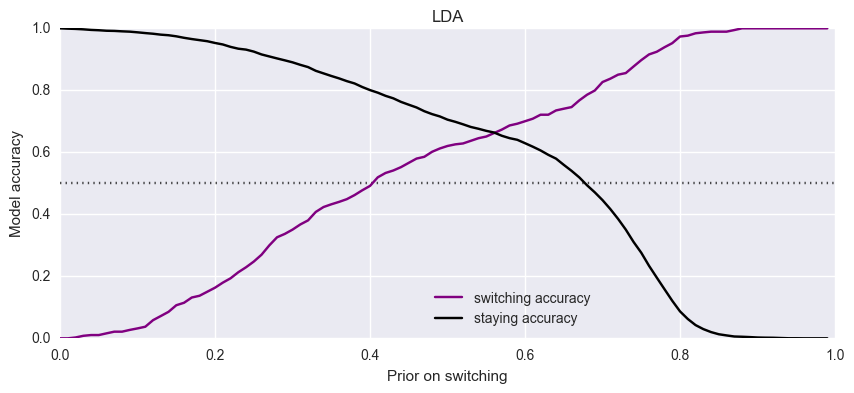

In [11]:
plt.figure(figsize=(10,4))
plt.plot(P,acc_cv[:,0],color='purple',label='switching accuracy')
plt.plot(P,acc_cv[:,1],color='black',label='staying accuracy')
plt.hlines(y=0.5,xmin=0,xmax=1,color='black',alpha=0.7,linestyle='dotted')
plt.legend(loc='lower right',bbox_to_anchor=[0.7,0])
plt.xlim(0,1)
plt.xlabel('Prior on switching')
plt.ylabel('Model accuracy')
plt.title('LDA')

Cool - this is way better with more data. With 1 session of data, the two lines crossed just below 50%. Now we are doing well above chance!

## LDA with tuned prior parameters

In [14]:
best_lda = discriminant_analysis.LinearDiscriminantAnalysis(priors=[0.40,0.6])
best_lda.fit(x_train,y_train)
y_predict = best_lda.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,disp=True,confusion=False)


          Predicted NO  Predicted YES
True NO         1046.0          563.0
True YES          50.0          100.0

F1: 0.246

Accuracy on class 0: 0.65
Accuracy on class 1: 0.67



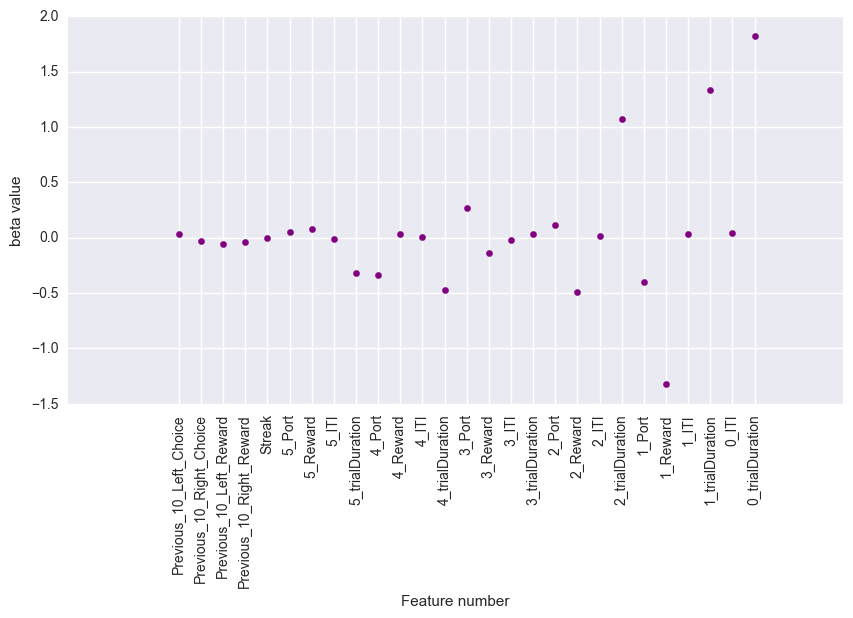

In [15]:
coefs = best_lda.coef_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),coefs[0],color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),data.columns.values,rotation='vertical')
plt.ylabel('beta value')
plt.xlabel('Feature number')

Interesting - the trial durations are the biggest betas here. Let's look at that ...

# Distributions of trial duration for the current trial being predicted
## This was the most weighted coefficient in the LDA model above

In [42]:
stay_0triald = data.loc[y==0,'0_trialDuration']
switch_0triald = data.loc[y==1,'0_trialDuration']

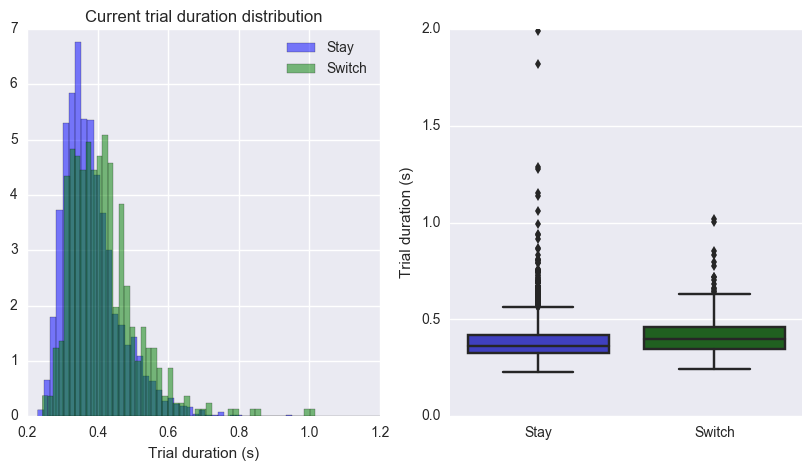

In [61]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.hist(data.loc[y==0,'0_trialDuration'].values,bins=100,color='blue',alpha=0.5,label='Stay',normed=True)
plt.hist(data.loc[y==1,'0_trialDuration'].values,bins=50,color='green',alpha=0.5,label='Switch',normed=True)
plt.title('Current trial duration distribution')
plt.xlim(0.2,1.2)
plt.legend(loc='upper right')
plt.xlabel('Trial duration (s)')

plt.subplot(122)
sns.boxplot(data = [data.loc[y==0,'0_trialDuration'].values,data.loc[y==1,'0_trialDuration'].values],palette = ['blue','green'],saturation=0.5)
plt.xticks([0,1],['Stay','Switch'])
plt.ylim(0,2)
plt.ylabel('Trial duration (s)')

It's not as striking as I thought it would be. But there is a difference. What about the other high betas?

## Plotting some more distributions for the most important features in the LDA model above:

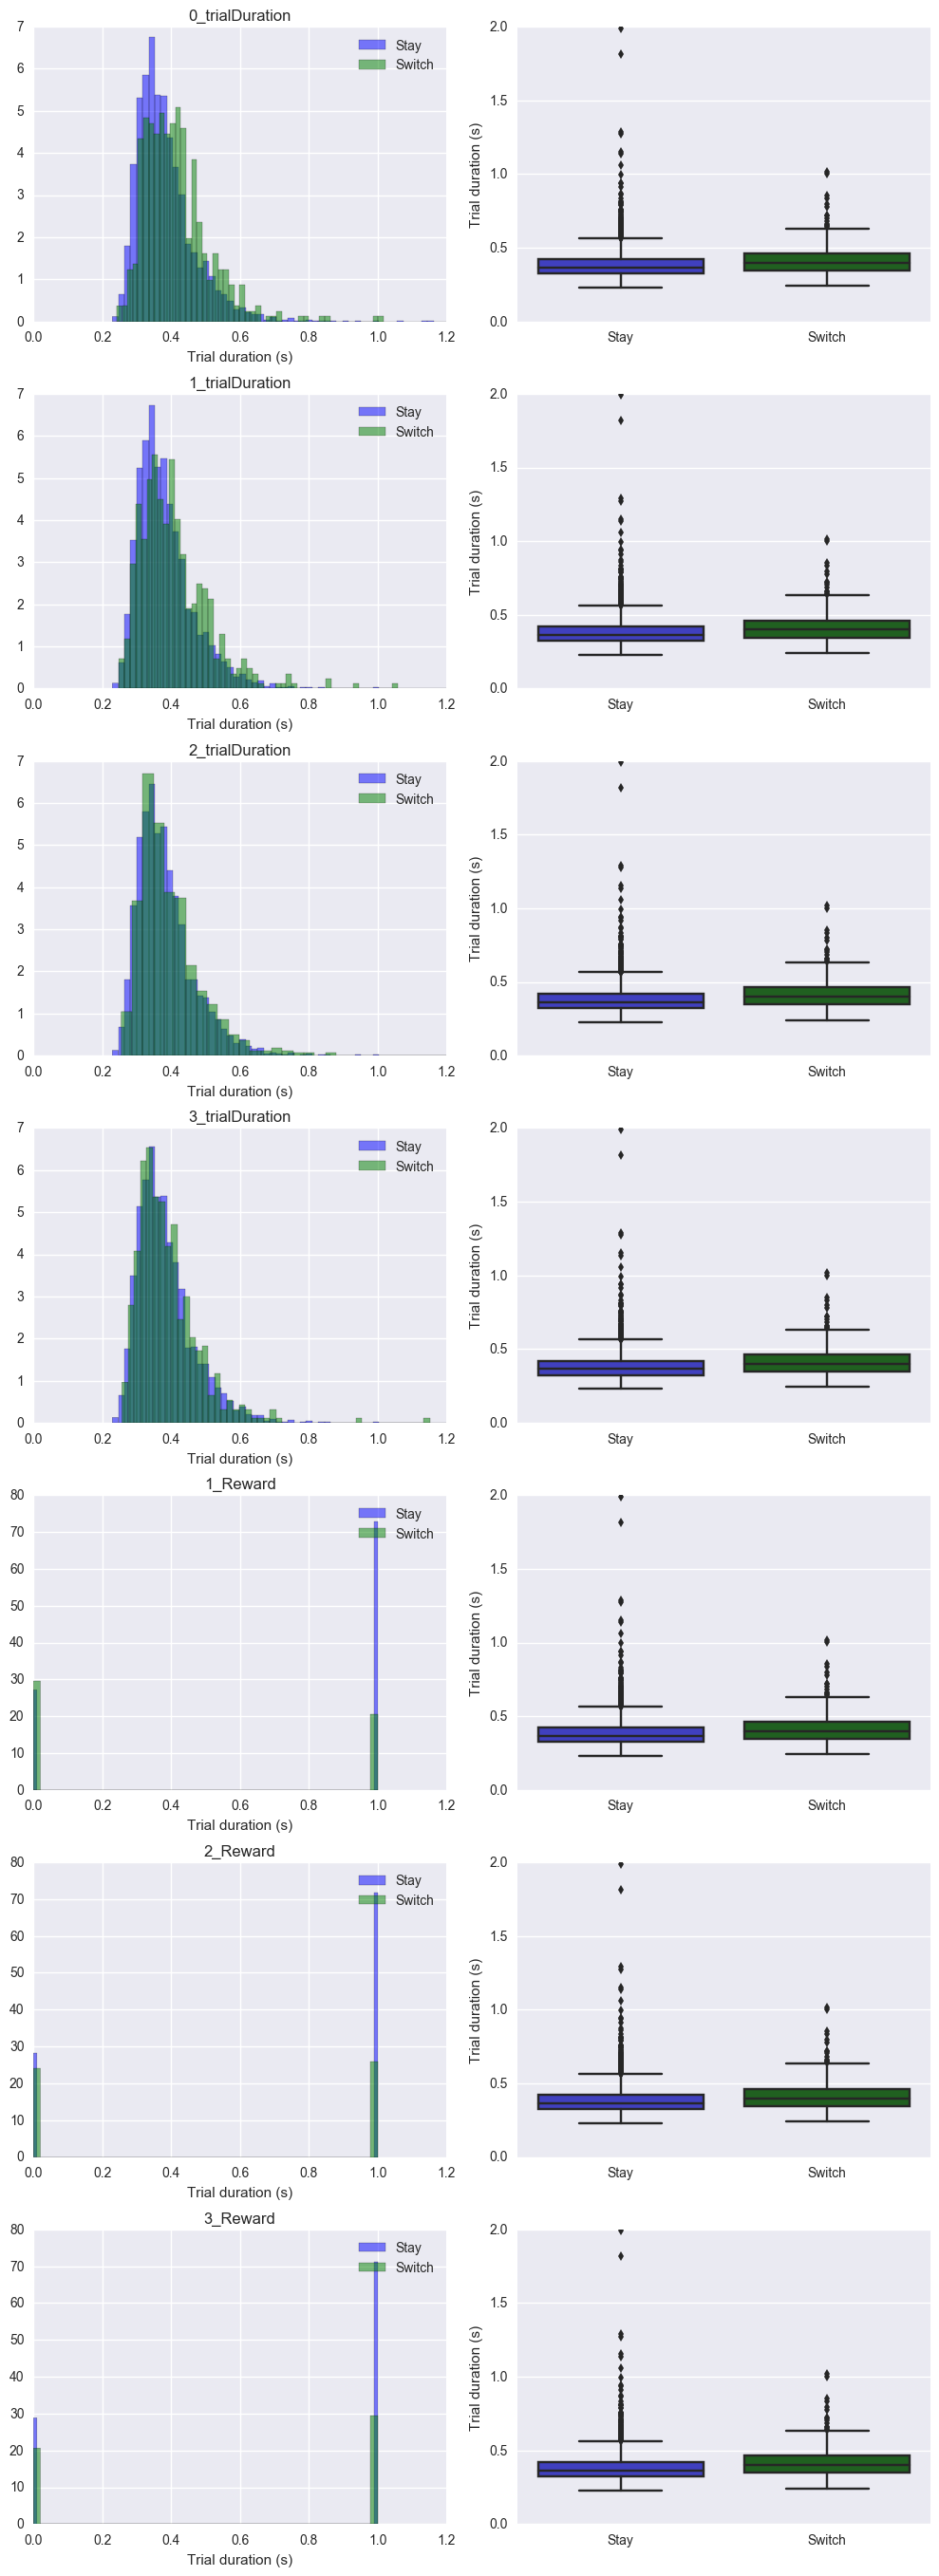

In [68]:
columns = ['0_trialDuration','1_trialDuration','2_trialDuration','3_trialDuration','1_Reward','2_Reward','3_Reward']
s = np.array([1,3,5,7,9,11,13])

plt.figure(figsize=(10,50))

for i,f in enumerate(columns):
    plt.subplot(13,2,s[i])
    plt.hist(data.loc[y==0,f].values,bins=100,color='blue',alpha=0.5,label='Stay',normed=True)
    plt.hist(data.loc[y==1,f].values,bins=50,color='green',alpha=0.5,label='Switch',normed=True)
    plt.title(f)
    plt.xlim(0,1.2)
    plt.legend(loc='upper right')
    plt.xlabel('Trial duration (s)')

    plt.subplot(13,2,s[i]+1)
    sns.boxplot(data = [data.loc[y==0,'0_trialDuration'].values,data.loc[y==1,'0_trialDuration'].values],palette = ['blue','green'],saturation=0.5)
    plt.xticks([0,1],['Stay','Switch'])
    plt.ylim(0,2)
    plt.ylabel('Trial duration (s)')

plt.tight_layout()

## Decision Tree

In [16]:
tree = Tree.DecisionTreeClassifier()
tree.fit(x_train,y_train)
y_predict = tree.predict(x_test)
acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO         1445.0          155.0
True YES         141.0           18.0

F1: 0.108

Accuracy on class 0: 0.90
Accuracy on class 1: 0.11



## Decision Tree: tune depth & class weights

In [17]:
D = np.array([2,5,10,20,50,100])
P = np.arange(0,1,0.01)

acc_cv = []

for i,d in enumerate(D):
    
    for p in P:
        prior = np.array([1.0-p,p])
        tree = Tree.DecisionTreeClassifier(max_depth=d,class_weight={0:prior[0],1:prior[1]})

        kf = cross_validation.KFold(x_train.shape[0],n_folds=3)
        cum_acc_pos = 0
        cum_acc_neg = 0

        for train_index,test_index in kf:
            x_train_cv = x_train[train_index,:]
            y_train_cv = y_train[train_index]
            x_test_cv = x_train[test_index,:]
            y_test_cv = y_train[test_index]

            tree.fit(x_train_cv,y_train_cv)
            y_predict = tree.predict(x_test_cv)

            acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)

            cum_acc_pos += acc_pos
            cum_acc_neg += acc_neg

        acc_cv.append([cum_acc_pos / 3.0,cum_acc_neg / 3.0])

acc_cv = np.asarray(acc_cv)
    

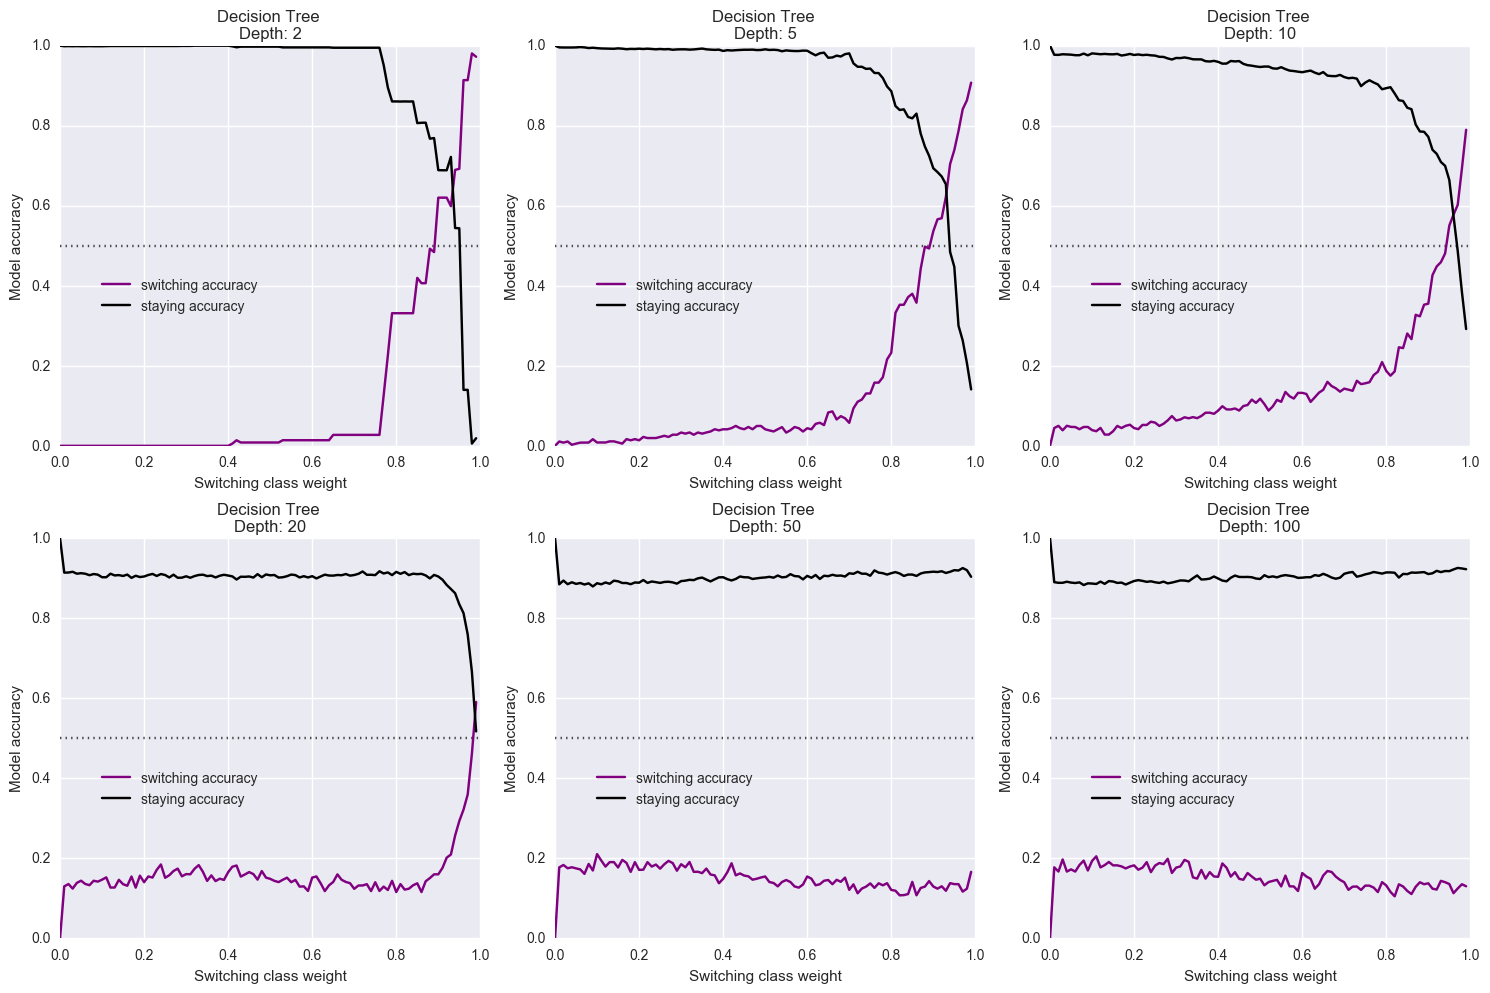

In [18]:
inds = np.arange(0,600,100)
plt.figure(figsize=(15,10))

for i,ind in enumerate(inds):
    
    plt.subplot(2,3,i+1)
    plt.plot(P,acc_cv[ind:ind+100,0],color='purple',label='switching accuracy')
    plt.plot(P,acc_cv[ind:ind+100,1],color='black',label='staying accuracy')
    plt.hlines(y=0.5,xmin=0,xmax=1,color='black',alpha=0.7,linestyle='dotted')
    plt.legend(loc='lower right',bbox_to_anchor=[0.5,0.3])
    plt.ylabel('Model accuracy')
    plt.xlabel('Switching class weight')
    plt.title('Decision Tree \nDepth: %.0f' % D[i])
plt.tight_layout()